# This notebook compares eukaryotic taxa seen in shotgun metagenomes with those in metabarcoding sequence data. It is designed to use the output of sourmash for shotgun metagenomes and DADA2, BLAST, and MEGAN LCA for metabarcoding data. In this example, sourmash databases were GTDB and MMETSP and BLAST database were NCBI-nr.

### This is currently written to assess taxa at the genus level, but can be modified for other levels of taxonomic resolution. Additionally, GTDB and MMETSP only contain microbial taxa (prokaryotic and eukaryotic, respectively). For higher organisms, different databases will be needed. I will address those questions in a separate script.

In [1]:
import pandas as pd
import os as os
import glob as glob
import numpy as np
import functools as ft
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## 01. Shotgun  metagenomes: Compile lists of observed taxa

### Function to generate domain- and genus-level data

In [2]:
def compile_taxa_lists(file, sample):
    tax = pd.read_csv(file)
    names = ['query name','rank','fraction','lineage','query_md5','query_filename',
         'f_weighted_at_rank','bp_match_at_rank']
    tax.columns = names
    # Get total number of bps in metagenome
    superk = tax[(tax['rank'] == 'superkingdom')]
    total_bps = superk['bp_match_at_rank'].sum()
    # Get eukaryotic bps in metagenome
    if tax['lineage'].isin(['Eukaryota']).any():
        euk_bps = tax[(tax['rank'] == 'superkingdom') & (tax['lineage'] == 'Eukaryota')]['bp_match_at_rank'].item()
    else:
        euk_bps = 0
    # Make dataframe with sample name and bps
    sample_bps = pd.DataFrame({'Sample' : pd.Series(a, dtype='str'), 
                           'total_bps': pd.Series(total_bps, dtype='int'),
                           'euk_bps': pd.Series(euk_bps, dtype='int')}) 
    tax = tax[tax['rank'] == 'genus']
    lineage = tax[['lineage', 'bp_match_at_rank']].copy()
    lineage[['Domain','Phylum','Class','Order','Family',
             'Genus']] = lineage['lineage'].str.split(';', n=6, expand=True)
    euks = lineage.loc[lineage['Domain'] == 'Eukaryota']
    euk_ord_genus = euks[['Order','Genus','bp_match_at_rank']].set_index('Genus')
    euk_ord_genus['bp_fraction'] = euk_ord_genus['bp_match_at_rank'].div(euk_bps)
    euk_ord_genus = euk_ord_genus.drop(columns=['bp_match_at_rank'])
    euk_ord_genus['Metagenome sample'] = sample
    return(euk_ord_genus, sample_bps)

### Apply functions to all samples in a directory

In [9]:
# Change this directory for each data set
#os.chdir("/Users/nastassia.patin/GitHub/eDNA-Visualizations/Euks_mgns_asvs_data/sourmash_summaries/Flyer2018")
os.chdir("/Users/nastassia.patin/GitHub/eDNA-Visualizations/Euks_mgns_asvs_data/sourmash_summaries/RREAS2018")
#os.chdir("/Users/nastassia.patin/GitHub/eDNA-Visualizations/Euks_mgns_asvs_data/sourmash_summaries/RREAS2019")

In [10]:
# empty data frame for genus- and order-level observations
df_gen_mgns = []
# empty data frame for all eukaryotic reads and base pairs
df_sample_bps = []

for file in glob.glob('*summarized.csv'):
    a, b = file.split('_int')
    gen, bps = compile_taxa_lists(file, a)
    df_gen_mgns.append(gen)
    df_sample_bps.append(bps)
    
df_gen_mgns = pd.concat(df_gen_mgns)
df_sample_bps = pd.concat(df_sample_bps)

### Assign identifiers to dataframes and repeat the process for other data sets

In [8]:
df_gen_mgns_Flyer2018 = df_gen_mgns
df_sample_bps_Flyer2018 = df_sample_bps

In [11]:
df_gen_mgns_RREAS2018 = df_gen_mgns
df_sample_bps_RREAS2018 = df_sample_bps

In [5]:
df_gen_mgns_RREAS2019 = df_gen_mgns
df_sample_bps_RREAS2019 = df_sample_bps

### Combine all dataframes

In [12]:
# taxonomy
df_gen_mgns = pd.concat([df_gen_mgns_RREAS2018, 
                         df_gen_mgns_Flyer2018, df_gen_mgns_RREAS2019], 
                        axis=0).reset_index()
df_gen_mgns.head(3)

,Genus,Order,bp_fraction,Metagenome sample
0,Minutocellus,Cymatosirales,0.459300,D0275A_S58
1,Skeletonema,Thalassiosirales,0.095169,D0275A_S58
2,Favella,Tintinnida,0.063909,D0275A_S58


In [14]:
# reads and base pairs
df_mgns_bps = pd.concat([df_sample_bps_RREAS2018, 
                         df_sample_bps_Flyer2018, df_sample_bps_RREAS2019], 
                        axis=0)
df_mgns_bps['euk_bp_fraction'] = df_mgns_bps['euk_bps'] / df_mgns_bps['total_bps']
df_mgns_bps.head(3)

,Sample,total_bps,euk_bps,euk_bp_fraction
0,D0275A_S58,185074000,18010000,0.097312
0,D0148A_S38,237230000,3029000,0.012768
0,D0085A_S13,202588000,1915000,0.009453


##### Calculate average fraction of eukaryotic base pairs across all samples

In [15]:
avg_bps = np.average(df_mgns_bps['euk_bp_fraction'])
avg_bps

0.10848123278114398

##### Calculate average fraction of total reads per sample from fraction of base pairs

In [16]:
os.chdir("/Users/nastassia.patin/GitHub/eDNA-Visualizations/Euks_mgns_asvs_data/")

mgn_stats = pd.read_csv('mgn_seq_stats.csv')
avg_seqs = np.average(mgn_stats['Avg num seqs'])
avg_seqs

42116990.333333336

#### Create a data frame with the average number of reads, average fraction of eukaryotic base pairs, and average fraction of eukaryotic reads for metagenomes

In [19]:
euk_frac_mgns = pd.DataFrame({'Sequence type': ['Metagenomes'], 'Avg num reads': [avg_seqs],
                           'Avg % euk bps/reads' : [avg_bps]})
euk_frac_mgns['Avg num euk reads'] = euk_frac_mgns['Avg % euk bps/reads'] * euk_frac_mgns['Avg num reads']
euk_frac_mgns

,Sequence type,Avg num reads,Avg % euk bps/reads,Avg num euk reads
0,Metagenomes,4.211699e+07,0.108481,4.568903e+06


## 02. Metabarcoding data: Compile lists of observed taxa

### Function to calculate total number of reads and bps per sample, filter out unclassified ASVs, and convert read counts to relative abundance values ('frequencies')

In [20]:
def counts_to_freq(file, marker_gene, read_len):
    asvs = pd.read_csv(file)
    asvs = asvs[(asvs['Kingdom'] != 'no_hit') & 
            (asvs['Kingdom'] != 'unassigned')] # Remove ASVs wit 'no_hit' or 'unassigned' in Kingdom
    # Get total number of reads and bps per sample
    asvs.loc['total']= asvs.sum()
    sample_reads = asvs.iloc[-1:,8:].reset_index()
    sample_reads = pd.melt(sample_reads, id_vars='index')
    sample_reads = sample_reads.iloc[:,-2:].rename(columns=
                                       {'variable':'%s Sample' % marker_gene, 
                                        'value':'total %s reads' % marker_gene})
    sample_reads['total %s bps' % marker_gene] = sample_reads['total %s reads' % marker_gene] * read_len # 127 bps for 18S, 321 bps for COI
    # Remove ASVs with no read counts in any samples
    asvs['sum'] = asvs.iloc[:,8:].sum(axis=1)
    asvs_filt = asvs[asvs['sum'] != 0]
    asvs_filt = asvs_filt.iloc[:-1,:-1]
    # Calculate frequencies
    # asvs_filt.iloc[:,8:] = asvs_filt.iloc[:,8:] / asvs_filt.iloc[-1,8:]
    # asvs_freq = asvs_filt[:-1]
    return(asvs_filt, sample_reads)

### Function to reformat taxa lists

##### Excluding taxa with unknown class/genus filters out A LOT of ASVs. Currently I have opted to keep in unknown taxa (except for reads with unknown 'Kingdom' which have already been filtered out in the previous function).

In [21]:
def reformat_ASV_table(df, marker_gene):
    samples = [col for col in df.columns if '1' in col] # Only sample column names have numbers
    cols_to_drop = ['lineage','Species']
    df = df.drop(cols_to_drop, axis=1)
    taxon = [x for x in df.columns if '1' not in x]
    df_melt = pd.melt(df, id_vars=taxon, value_vars=samples)
    df_asvs = df_melt.rename(columns = {'variable':'%s Sample' % marker_gene, 
                                        'value':'%s read count' % marker_gene})
    #mask = ['no_hit', 'unknown', 'unassigned'] # identify ASVs where taxon is unknown or unassigned
    #genus = ''.join('Genus') # Convert list to string
    #df_asvs = df_melt.loc[~df_melt['Kingdom'].isin(mask), :]
    #df_asvs = df_melt.loc[~df_melt['Class'].isin(mask), :]
    #df_asvs = df_melt.loc[~df_melt['Genus'].isin(mask), :]
    # df_asvs = df_asvs[df_asvs['%s Frequency' % marker_gene] != 0]
    #df_asvs = df_asvs.drop_duplicates()
    return(df_asvs)

### Generate dataframes for (1) class-level taxon frequences per sample and (2) reads and bps per sample

#### COI

In [22]:
os.chdir("/Users/nastassia.patin/GitHub/eDNA-Visualizations/Euks_mgns_asvs_data/COI comparison")

In [23]:
df_tax_COI = []
df_reads_COI = []

for file in glob.glob('*mgnmatches.csv'):
    taxa_filt, reads = counts_to_freq(file, 'COI', 321)
    genus = reformat_ASV_table(taxa_filt, 'COI')
    df_tax_COI.append(genus)
    df_reads_COI.append(reads)

df_tax_COI = pd.concat(df_tax_COI, axis=0)
df_reads_COI = pd.concat(df_reads_COI)

In [24]:
#df_tax_COI.tail(3)
df_reads_COI.head(3)

,COI Sample,total COI reads,total COI bps
0,Lasker18Sc122_3_D0052,15876,5096196
1,Lasker18Sc122_5_D0053,28261,9071781
2,Lasker18Sc122_17_D0057,42076,13506396


#### 18S

In [25]:
os.chdir("/Users/nastassia.patin/GitHub/eDNA-Visualizations/Euks_mgns_asvs_data/18S comparison")

In [26]:
df_tax_18S = []
df_reads_18S = []

for file in glob.glob('*mgnmatches.csv'):
    taxa_filt, reads = counts_to_freq(file, '18S', 127)
    genus = reformat_ASV_table(taxa_filt, '18S')
    df_tax_18S.append(genus)
    df_reads_18S.append(reads)

df_tax_18S = pd.concat(df_tax_18S, axis=0)
df_reads_18S = pd.concat(df_reads_18S)

In [27]:
#df_tax_18S.tail(3)
df_reads_18S.head(3)

,18S Sample,total 18S reads,total 18S bps
0,CN18FESPkoa_SC24,94585,12012295
1,CN18FESPkoa_SC26,45330,5756910
2,CN18FESPkoa_SC29,89395,11353165


## 03. Compare total numbers/fractions of eukaryotic reads in metagenomes and amplicons

#### Calculate average # total reads and average # eukaryotic reads for amplicon samples

In [28]:
def calculate_eukaryotic_read_fraction(df_tax, df_reads, marker_gene):
    kingdoms = df_tax[['Kingdom', '%s Sample' % marker_gene, '%s read count' % marker_gene]]
    kingdoms = kingdoms.groupby(['Kingdom', '%s Sample' % marker_gene]).sum()
    euks = kingdoms.xs('Eukaryota', level=0).reset_index()
    euks['Domain'] = 'Eukaryota'
    euk_fracs = pd.merge(df_reads, euks, on='%s Sample' % marker_gene)
    euk_fracs['%s euk reads percent' % marker_gene] = euk_fracs['%s read count' % marker_gene] / euk_fracs['total %s reads' % marker_gene]
    return(euk_fracs)

In [29]:
euk_fracs_18S = calculate_eukaryotic_read_fraction(df_tax_18S, df_reads_18S, '18S')
euk_fracs_18S.head(3)

,18S Sample,total 18S reads,total 18S bps,18S read count,Domain,18S euk reads percent
0,CN18FESPkoa_SC24,94585,12012295,94584,Eukaryota,0.999989
1,CN18FESPkoa_SC26,45330,5756910,45329,Eukaryota,0.999978
2,CN18FESPkoa_SC29,89395,11353165,89393,Eukaryota,0.999978


In [30]:
euk_fracs_COI = calculate_eukaryotic_read_fraction(df_tax_COI, df_reads_COI, 'COI')
euk_fracs_COI.head(3)

,COI Sample,total COI reads,total COI bps,COI read count,Domain,COI euk reads percent
0,Lasker18Sc122_3_D0052,15876,5096196,15876,Eukaryota,1.0
1,Lasker18Sc122_5_D0053,28261,9071781,28261,Eukaryota,1.0
2,Lasker18Sc122_17_D0057,42076,13506396,42076,Eukaryota,1.0


In [31]:
euk_frac_mgns

,Sequence type,Avg num reads,Avg % euk bps/reads,Avg num euk reads
0,Metagenomes,4.211699e+07,0.108481,4.568903e+06


In [32]:
new_row = pd.DataFrame({'Sequence type': '18S', 
           'Avg num reads': np.average(euk_fracs_18S['total 18S reads']),
           'Avg % euk bps/reads': np.average(euk_fracs_18S['18S euk reads percent']),
            'Avg num euk reads': np.average(euk_fracs_18S['18S read count'])},
                      index=[0])
euk_frac_df = pd.concat([new_row, euk_frac_mgns.loc[:]]).reset_index(drop=True)

In [33]:
new_row = pd.DataFrame({'Sequence type': 'COI', 
           'Avg num reads': np.average(euk_fracs_COI['total COI reads']),
           'Avg % euk bps/reads': np.average(euk_fracs_COI['COI euk reads percent']),
            'Avg num euk reads': np.average(euk_fracs_COI['COI read count'])},
                      index=[0])
euk_frac_df = pd.concat([new_row, euk_frac_df.loc[:]]).reset_index(drop=True)

In [37]:
euk_frac_df['Total reads'] = 1.0
euk_frac_df['Avg num prok reads'] = euk_frac_df['Avg num reads'] - euk_frac_df['Avg num euk reads']
euk_frac_df.to_csv("Percent_euk_reads_comparison.csv", index=False)

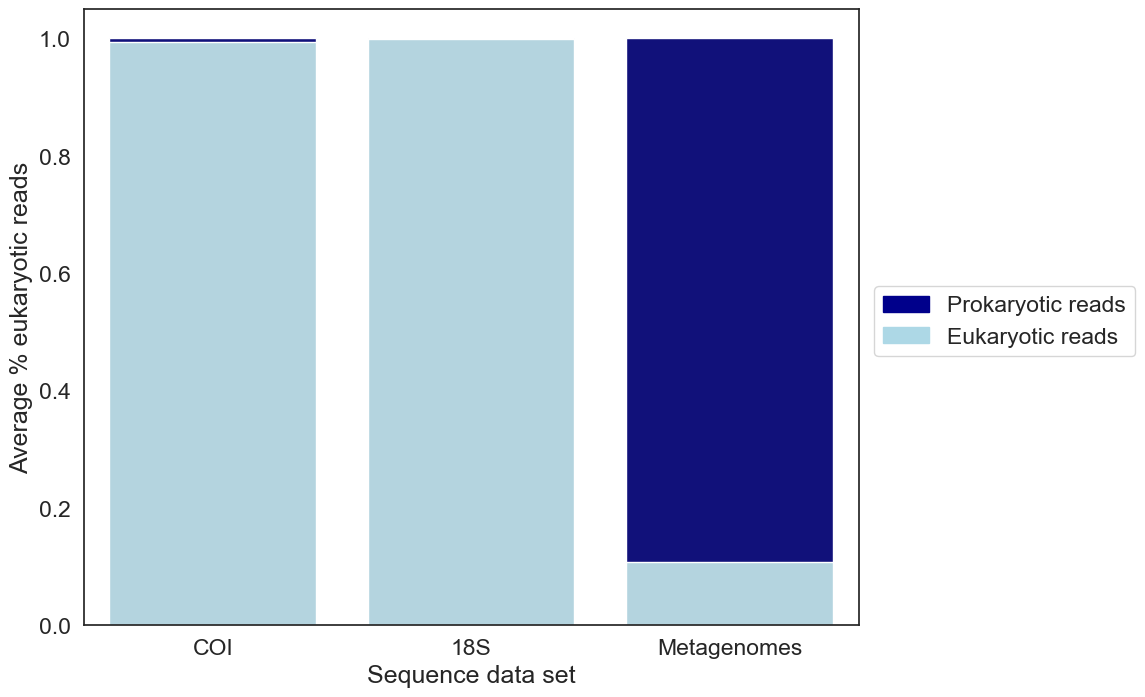

In [35]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(sns.color_palette('colorblind'))

# bar chart 1 -> top bars (bac + arc reads)
bar1 = sns.barplot(data=euk_frac_df, x='Sequence type',  
                   y='Total reads', color='darkblue')

# bar chart 2 -> bottom bars (eukaryotic reads)
bar2 = sns.barplot(data=euk_frac_df, x='Sequence type',  
                   y='Avg % euk bps/reads', color='lightblue')

plt.ylabel('Average % eukaryotic reads', size=18)
plt.xlabel('Sequence data set', size=18)

plt.ylim(0, 1.05)

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Prokaryotic reads')
bottom_bar = mpatches.Patch(color='lightblue', label='Eukaryotic reads')
plt.legend(handles=[top_bar, bottom_bar], bbox_to_anchor=(1.02, 0.55), 
           loc='upper left', borderaxespad=0)

plt.savefig('eCruises2018_2019_prok_vs_euk_reads.png', format='png', 
            dpi=1200, bbox_inches='tight')
# show the graph
plt.show()

## 04. Compare frequencies of taxa seen in paired samples

In [260]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises_TIMESERIES/Euks-mgns-asvs")

#### Load file showing paired sample names and turn pairs into a dictionary

In [261]:
file = 'eCruises2018_2019_mgn_asv_paired_samples.csv'
pairs = pd.read_csv(file)

#### Add paired sample names to ASV and metagenome genus lists

In [262]:
df_gen_asvs_paired = df_gen_asvs.merge(pairs, how='left', on='ASV sample')
df_gen_mgns_paired = df_gen_mgns.merge(pairs, how='left', on='Metagenome sample')
df_gen_asvs_paired.head(3)

NameError: name 'df_gen_asvs' is not defined

In [238]:
df_gen_mgns_paired.head(3)

,Genus,Order,bp_fraction,Metagenome sample,ASV sample
0,Bathycoccus,Mamiellales,0.436027,D0079A,Lasker18Sc124_19_D0079
1,Micromonas,Mamiellales,0.183082,D0079A,Lasker18Sc124_19_D0079
2,Aureococcus,Pelagomonadales,0.099370,D0079A,Lasker18Sc124_19_D0079
3,Pelagomonas,Pelagomonadales,0.055601,D0079A,Lasker18Sc124_19_D0079
4,Bathycoccus,Mamiellales,0.043045,D0079A,Lasker18Sc124_19_D0079
...,...,...,...,...,...
3464,Isochrysis,Isochrysidales,0.019352,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1
3465,Polarella,Suessiales,0.018868,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1
3466,Thalassiosira,Thalassiosirales,0.016933,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1
3467,Phaeocystis,Phaeocystales,0.014514,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1


#### Extract genera seen ONLY in matched sample pairs

In [272]:
df_gen_pairmatches = df_gen_mgns_paired.merge(df_gen_asvs_paired, how='inner', 
                                            on=['Order', 'Genus', 'ASV sample', 
                                                'Metagenome sample'])
#df_gen_pairmatches['Size'] = 7
df_gen_pairmatches

,Genus,Order,bp_fraction,Metagenome sample,ASV sample,ASV Frequency
0,Bathycoccus,Mamiellales,0.436027,D0079A,Lasker18Sc124_19_D0079,0.00249
1,Bathycoccus,Mamiellales,0.436027,D0079A,Lasker18Sc124_19_D0079,0.001271
2,Bathycoccus,Mamiellales,0.436027,D0079A,Lasker18Sc124_19_D0079,0.014332
3,Bathycoccus,Mamiellales,0.436027,D0079A,Lasker18Sc124_19_D0079,0.014485
4,Bathycoccus,Mamiellales,0.436027,D0079A,Lasker18Sc124_19_D0079,0.000152
...,...,...,...,...,...,...
9078,Phaeocystis,Phaeocystales,0.014514,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1,0.000225
9079,Phaeocystis,Phaeocystales,0.014514,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1,0.000061
9080,Phaeocystis,Phaeocystales,0.014514,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1,0.000031
9081,Phaeocystis,Phaeocystales,0.014514,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1,0.000051


In [273]:
# need to do this for the reg plot, not for the scatter plot
df_gen_pairmatches['ASV Frequency'] = pd.to_numeric(df_gen_pairmatches['ASV Frequency'])

In [274]:
df_gen_pairmatches['ASV Frequency'].dtype

dtype('float64')

## 04. Plot frequencies of taxa seen in both data sets against each other

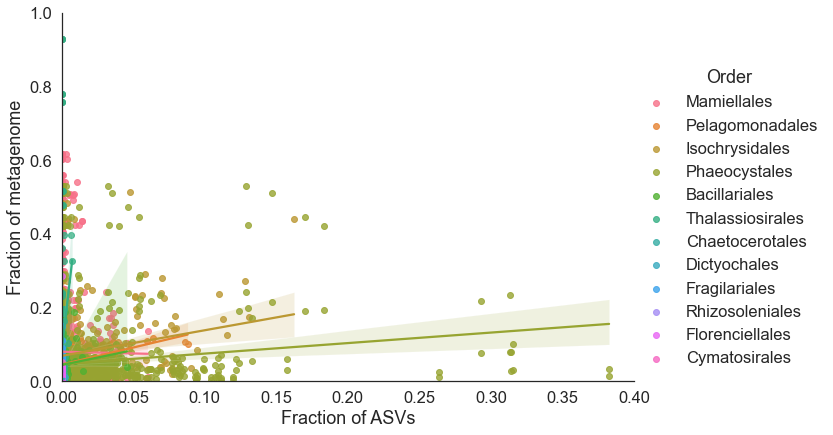

In [281]:
#plt.figure(figsize=(12,8))
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(sns.color_palette('colorblind'))

# scatter plot with ASV frequency on x axis and metagenome frequency on y axis
#scatter = sns.scatterplot(data=df_gen_pairmatches, x='ASV Frequency',  
 #                         y='bp_fraction', color='darkblue', hue='Family', alpha=1) # size='Size'

# scatter plot with regression line
sns.lmplot(data=df_gen_pairmatches, x='ASV Frequency', y='bp_fraction',
           height=6, aspect=1.5, hue='Order')
#plt.show()

plt.ylabel('Fraction of metagenome', size=18)
plt.xlabel('Fraction of ASVs', size=18)

plt.ylim(0, 1)
plt.xlim(0, 0.4)
plt.savefig('eCruises2018_2019_genera_fraction_COI_vs_mgns_regression_orders.svg', format='svg', 
            dpi=1200, bbox_inches='tight')